<a href="https://colab.research.google.com/github/AnandShegde/pml_baselines/blob/main/pystan/LinearRegression_learnNoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  import pystan
except:
  %pip install -qq pystan
  import pystan
import tensorflow as tf
import numpy as np
import seaborn as sns
import numpy as np
import jax
import jax.numpy as jnp
!pip install tensorflow_probability
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import arviz as az

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pickle
with open("/content/LinearRegression/linear_regression",'rb') as f:
    data = pickle.load(f)
data

{'data': {'x': array([[ 1.7598495 ],
         [-0.23643708],
         [ 3.1509051 ],
         [-0.79705334],
         [-2.500547  ],
         [ 1.6101036 ],
         [ 0.14806175],
         [ 0.05331182],
         [ 2.6665907 ],
         [-0.14456654]], dtype=float32), 'y': array([[ 9.011515 ],
         [ 5.4843464],
         [ 9.670069 ],
         [ 1.1274505],
         [-1.283633 ],
         [ 7.062801 ],
         [ 3.6567392],
         [ 2.2533112],
         [10.321623 ],
         [ 2.2750926]], dtype=float32)},
 'noise_variance': 1,
 'prior': {'alpha': 1,
  'beta': 1,
  'mean': array([14. ,  7.3], dtype=float32),
  'var': array([[10.,  0.],
         [ 0., 10.]], dtype=float32)}}

In [ ]:
X = data['data']['x']
Y = data['data']['y']
Y=Y.flatten()
prior_alpha = data['prior']['alpha']
prior_beta = data['prior']['beta']

def identity_trans(x):
    return jnp.append(jnp.ones((m,1)),x,axis=1)
m = X.shape[0]
X = identity_trans(X)
mean_prior = data['prior']['mean']
var_prior = data['prior']['var']
diag=jnp.identity(10)

In [ ]:
LinearRegression_NormalDist="""
data {
  int<lower=0> N;
  matrix[N,2] x;
  vector[N] y;
  vector[2] mean_prior;
  matrix[2,2] var_prior;
  matrix[10,10] diag;
  real prior_alpha;
  real prior_beta;
}
parameters {
  vector[2] theta;
  real noise;
}
model {
  theta ~ multi_normal(mean_prior,var_prior);
  noise ~ inv_gamma(prior_alpha, prior_beta);
  y ~ multi_normal(x*theta,diag*noise);
}
"""

In [ ]:
model_LinearReg_Normal = pystan.StanModel(model_code=LinearRegression_NormalDist)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9e4291f2904d7c56277134d8e80f0cbb NOW.


In [ ]:
data = {
    'N':10,
    'x':X,
    'y':Y,
    'mean_prior':mean_prior,
    'var_prior':var_prior,
    'diag':diag,
    'prior_alpha':prior_alpha,
    'prior_beta':prior_beta
}

In [ ]:
model_LinearReg_Normal_hmc = model_LinearReg_Normal.sampling(data=data, chains=8, warmup=500, iter=1500,control=dict(adapt_delta=0.99))

In [ ]:
model_LinearReg_Normal_hmc

Inference for Stan model: anon_model_9e4291f2904d7c56277134d8e80f0cbb.
8 chains, each with iter=1500; warmup=500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]    3.9  8.3e-3   0.47   3.03    3.6   3.89   4.18   4.87   3225    1.0
theta[2]   2.21  4.3e-3   0.27   1.68   2.04    2.2   2.38   2.74   3839    1.0
noise      1.99    0.03   1.19   0.77   1.26   1.69   2.36   4.86   1463    1.0
lp__     -16.37    0.04   1.66 -20.46 -17.13 -15.95 -15.15 -14.48   1554    1.0

Samples were drawn using NUTS at Thu Jun 23 12:02:51 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effa45f2210>,
      dtype=object)

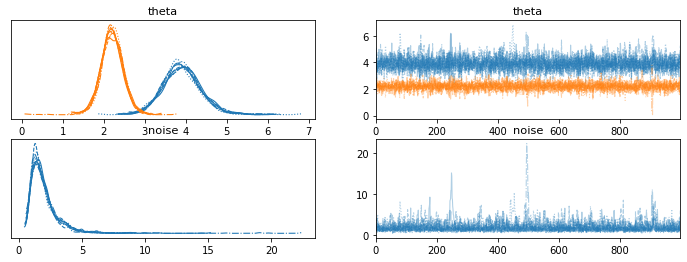

In [ ]:
az.plot_trace(model_LinearReg_Normal_hmc, figsize = (12, 4))

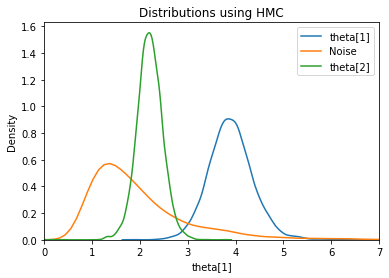

In [ ]:
model_LinearReg_Normal_df = model_LinearReg_Normal_hmc.to_dataframe()
alpha_hmc = model_LinearReg_Normal_df['theta[1]']
noise_hmc=model_LinearReg_Normal_df['noise']
sns.kdeplot(alpha_hmc,label="theta[1]")
sns.kdeplot(noise_hmc,label="Noise")
beta_hmc = model_LinearReg_Normal_df['theta[2]']
sns.kdeplot(beta_hmc,label="theta[2]")

plt.xlim(0,7)
plt.title("Distributions using HMC")
plt.legend()
plt.show()

#**Using Variational Inference**

In [ ]:
model_LinearReg_Normal_vi=model_LinearReg_Normal.vb(data=data)

In [ ]:
model_LinearReg_Normal_vi['mean_pars']

[3.8807405900780982, 2.176600863819519, 1.8504962984969135]

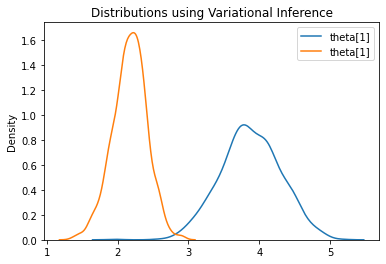

In [ ]:
alpha_vi=np.array(model_LinearReg_Normal_vi.get('sampler_params')[0])
sns.kdeplot(alpha_vi,label="theta[1]")

beta_vi=np.array(model_LinearReg_Normal_vi.get('sampler_params')[1])
sns.kdeplot(beta_vi,label="theta[1]")

plt.title("Distributions using Variational Inference")
plt.legend()
plt.show()

In [ ]:
def posterior(phi,m_0, t, S_0, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = jnp.linalg.inv(S_0) + beta * phi.T.dot(phi)
    S_N = jnp.linalg.inv(S_N_inv)
    m_N =S_N@(jnp.linalg.inv(S_0)@m_0+beta *phi.T.dot(t))

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N

In [ ]:
mean,cov = posterior(X, mean_prior, Y, var_prior,1)

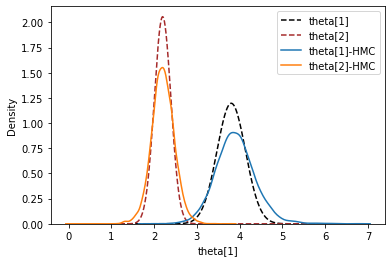

In [ ]:
# sns.kdeplot(alpha_vi,label="theta[1]-VI")
# sns.kdeplot(beta_vi,label="theta[2]-VI")
normal1 = tfd.Normal(mean[0],jnp.sqrt(cov[0,0]))
x = jnp.linspace(1,6,1000)
pdf1 = normal1.prob(x)
plt.plot(x,pdf1,label="theta[1]",linestyle="dashed",color="black")

normal2 = tfd.Normal(mean[1],jnp.sqrt(cov[1,1]))
pdf2=  normal2.prob(x)
plt.plot(x,pdf2,label="theta[2]",linestyle="dashed",color="brown")

sns.kdeplot(alpha_hmc,label="theta[1]-HMC")
sns.kdeplot(beta_hmc,label="theta[2]-HMC")

plt.legend()
plt.show()

In [ ]:
alpha_hmc=jnp.array(alpha_hmc)
beta_hmc=jnp.array(beta_hmc)
data={'alpha':alpha_hmc,'beta':beta_hmc}


In [ ]:
theta0=jnp.array(alpha_hmc)
theta1=jnp.array(beta_hmc)
noise=jnp.array(noise_hmc)

results=jnp.array([theta0,theta1,noise])
with open("/content/LinearRegression_data/HMC_Stan",'wb') as f:
    pickle.dump(results, f,protocol = 1)